In [ ]:
# !pip install tensorflow-privacy
# !pip install --upgrade tensorflow-estimator==2.3.0
# !pip install --upgrade tensorflow==2.14.0
# !pip install deap

In [1]:
# =========================
# Standard Library
# =========================
import os
import random
import time
import warnings

# =========================
# Third-Party: Numerical / Data
# =========================
import numpy as np
import pandas as pd

# =========================
# Third-Party: Visualization
# =========================
import matplotlib.pyplot as plt
import seaborn as sns

# =========================
# Third-Party: sklearn
# =========================
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.utils import resample, shuffle
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    auc,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    precision_score,
    recall_score,
)

# =========================
# Third-Party: Imbalanced-Learn
# =========================
from imblearn.over_sampling import RandomOverSampler

# =========================
# Third-Party: TensorFlow & Privacy
# =========================
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    LSTM,
    Dense,
    Dropout,
    Flatten,
    Conv2D,
    MaxPooling2D,
)
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import (
    TruePositives,
    TrueNegatives,
    FalsePositives,
    FalseNegatives,
)

import tensorflow_privacy
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy

# =========================
# Third-Party: Genetic Algorithm (DEAP)
# =========================
from deap import base, creator, tools

# =========================
# Warnings
# =========================
warnings.filterwarnings("ignore", category=UserWarning)


## Load and Preprocess Data

In [2]:
data  = pd.read_csv(r'\Users\dmachooka\Downloads\dmac\RT_IOT2022.csv', index_col = 0)

In [3]:
# Multiclass problem
target_column = 'Attack_type'
display(data[target_column].unique())
num_classes = data[target_column].nunique()

array(['MQTT_Publish', 'Thing_Speak', 'Wipro_bulb', 'ARP_poisioning',
       'DDOS_Slowloris', 'DOS_SYN_Hping', 'Metasploit_Brute_Force_SSH',
       'NMAP_FIN_SCAN', 'NMAP_OS_DETECTION', 'NMAP_TCP_scan',
       'NMAP_UDP_SCAN', 'NMAP_XMAS_TREE_SCAN'], dtype=object)

In [4]:
data[target_column].value_counts()

Attack_type
DOS_SYN_Hping                 94659
Thing_Speak                    8108
ARP_poisioning                 7750
MQTT_Publish                   4146
NMAP_UDP_SCAN                  2590
NMAP_XMAS_TREE_SCAN            2010
NMAP_OS_DETECTION              2000
NMAP_TCP_scan                  1002
DDOS_Slowloris                  534
Wipro_bulb                      253
Metasploit_Brute_Force_SSH       37
NMAP_FIN_SCAN                    28
Name: count, dtype: int64

In [5]:
# Lets keep top 3 groups and implement imbalancing
# simplify the problem lets only predict for top 3 conditions
data = data[data[target_column].isin(['DOS_SYN_Hping','Thing_Speak','ARP_poisioning'])]

In [6]:
# Add Upsampling
# Separate features and target
X = data.drop(columns=[target_column])
y = data[target_column]

# Perform upsampling
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

data = pd.concat([X_resampled, y_resampled], axis=1)

C:\Users\dmachooka\AppData\Local\anaconda3\envs\tf-privacy\lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
C:\Users\dmachooka\AppData\Local\anaconda3\envs\tf-privacy\lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


In [7]:
# Label encode the target column
from sklearn.preprocessing import LabelEncoder

# Instantiate LabelEncoder
label_encoder = LabelEncoder()

# Encode the target column
data[target_column] = label_encoder.fit_transform(data[target_column])

In [8]:
# Identify non-numeric columns (only two so dropping)
print(data.select_dtypes(include='object').columns)

data.drop(['proto', 'service'], axis=1, inplace=True)

Index(['proto', 'service'], dtype='object')


In [9]:
target_column = 'Attack_type'
categorical_columns = [col for col in data.columns if col not in [target_column]] # Other columns

X = data.drop(target_column, axis=1)
y = data[target_column]

# Split into training test and validation datasets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25, random_state=42)

X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.4, random_state=42)



# Standard Scaling
scaler = StandardScaler()

#Perfom feature scaling for the training set
X_train_scaled = X_train.copy()
X_train_scaled[categorical_columns] = scaler.fit_transform(X_train[categorical_columns])

#Perfom feature scaling for the training set
X_valid_scaled = X_valid.copy()
X_valid_scaled[categorical_columns] = scaler.transform(X_valid[categorical_columns])

#Perfom feature scaling for the test set
X_test_scaled = X_test.copy()
X_test_scaled[categorical_columns] = scaler.transform(X_test[categorical_columns])

In [10]:
# Function to plot loss curves
def plot_loss(history1, history2=None):
    plt.figure(figsize=(12, 4))

    # Plot training & validation loss values for the first model
    plt.subplot(1, 2, 1)
    plt.plot(history1.history['loss'])
    plt.plot(history1.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot training & validation accuracy values for the first model
    plt.subplot(1, 2, 2)
    plt.plot(history1.history['accuracy'])
    plt.plot(history1.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='lower right')

    if history2 is not None:
        # Plot training & validation loss values for the second model
        plt.subplot(1, 2, 1)
        plt.plot(history2.history['loss'], linestyle='dashed')
        plt.plot(history2.history['val_loss'], linestyle='dashed')
        plt.legend(['Train', 'Validation', 'Train Privacy', 'Validation Privacy'], loc='upper right')

        # Plot training & validation accuracy values for the second model
        plt.subplot(1, 2, 2)
        plt.plot(history2.history['accuracy'], linestyle='dashed')
        plt.plot(history2.history['val_accuracy'], linestyle='dashed')
        plt.legend(['Train', 'Validation', 'Train Privacy', 'Validation Privacy'], loc='lower right')

    plt.tight_layout()
    plt.show()

## Gene Alg Privacy

In [73]:
gene_alg = True
# ---------- Search space ----------
ACTIVATIONS = ['gelu', 'swish', 'silu', 'relu']
OPTIMIZERS = ['sgd', 'adam']
LAYERS_CHOICES = [4, 6, 8]
# 'binary_crossentropy' , 'categorical_crossentropy'
LOSSES = [ 'sparse_categorical_crossentropy']
LEARNING_RATES = [0.001, 0.0001]
BATCH_SIZES = [ 64,128, 256]
EPOCHS_CHOICES = [23, 30, 50, 100]
UNITS_CHOICES = [128, 256, 512]

In [74]:
def evaluate_nn_with_privacy(hyperparams):



     # -------- Extract Hyperparameters --------
    units = hyperparams["units"]          # list of 3 ints e.g. [128, 256, 128]
    dropouts = hyperparams["dropouts"]    # list of 3 floats
    learning_rate = hyperparams["learning_rate"]
    batch_size = hyperparams["batch_size"]
    epochs = hyperparams["epochs"]
    noise_multiplier = hyperparams.get("noise_multiplier", 1.3)
    
    # units = hyperparams['units']
    # dropouts = hyperparams['dropouts']
    # learning_rate = hyperparams['learning_rate']
    # noise_multiplier = 1.3
    # Define MLP model with DP
    mlp_model_privacy = tf.keras.Sequential([
        Dense(units=units[0], activation='relu', input_shape=(len(categorical_columns),)),
        Dropout(rate=dropouts[0]),
        Dense(units=units[1], activation='relu'),
        Dropout(rate=dropouts[1]),
        Dense(units=units[2], activation='relu'),
        Dropout(rate=dropouts[2]),
        Dense(num_classes, activation='softmax')
    ])

    # Create a DP optimizer
    optimizer = tensorflow_privacy.DPKerasSGDOptimizer(
        l2_norm_clip=1.0,
        noise_multiplier=noise_multiplier,
        num_microbatches=1,
        learning_rate=learning_rate
    )

    # Compile the model with the DP optimizer and loss function
    mlp_model_privacy.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Perform 6-fold cross-validation
    kfold = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
    cv_results = []

    for train_index, test_index in kfold.split(X_train_scaled[categorical_columns], y_train):
        X_train_fold, X_val_fold = X_train_scaled[categorical_columns].iloc[train_index], X_train_scaled[categorical_columns].iloc[test_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        # Train the model with DP for this fold
        mlp_model_privacy.fit(X_train_fold, y_train_fold, epochs=10, batch_size=16, verbose=0)
        # _, val_accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
        # cv_results.append(val_accuracy)
        # Predict class labels for F1
        y_pred_proba = mlp_model_privacy.predict(X_val_fold, verbose=0)
        y_pred = np.argmax(y_pred_proba, axis=1)   # convert softmax → class

        # Compute F1 ,macro compute each class separate,weighted doesnt penalize imbalance,micro best for extreme imbalance less interpretable
        f1 = f1_score(y_val_fold, y_pred, average="macro")  # or "macro", "weighted"
        cv_results.append(f1)

    # Extract trainable variables from the model
    trainable_variables = mlp_model_privacy.trainable_variables

    # Compute privacy budget
    privacy_report = compute_dp_sgd_privacy.compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy_statement(
        number_of_examples=len(X_train_scaled),
        batch_size=batch_size,
        noise_multiplier=1.3,
        num_epochs=30,
        delta=1e-5
    )

    epsilon = None

    # Case A: report is an object with epsilon attr
    if hasattr(privacy_report, "epsilon"):
        epsilon = privacy_report.epsilon

    # Case B: report is a tuple (epsilon, something)
    elif isinstance(privacy_report, tuple) and len(privacy_report) >= 1 and isinstance(privacy_report[0], (float, int)):
        epsilon = privacy_report[0]

    # Case C: report is a string
    elif isinstance(privacy_report, str):
        import re
        match = re.search(r"epsilon[^0-9]*([0-9.]+)", privacy_report.lower())
        if match:
            epsilon = float(match.group(1))

    score = np.mean(cv_results) - epsilon # GA maximizes score by default

    return score,

In [75]:
def custom_crossover(ind1, ind2):
    """Two-point crossover"""
    keys = list(ind1.keys())
    cx1, cx2 = sorted([random.randint(1, len(keys)-1) for _ in range(2)])
    for i in range(cx1, cx2):
        key = keys[i]
        ind1[key], ind2[key] = ind2[key], ind1[key]
    return ind1, ind2

def custom_mutation(ind):
    """Random mutation of one hyperparameter"""
    param = random.choice(list(ind.keys()))
    if param == 'units':
        n_layers = len(ind['units'])
        ind['units'] = [random.choice(UNITS) for _ in range(n_layers)]
    elif param == 'dropouts':
        ind['dropouts'] = [random.uniform(0.1, 0.5) for _ in range(len(ind['dropouts']))]
    elif param == 'activation':
        ind['activation'] = random.choice(ACTIVATIONS)
    elif param == 'optimizer':
        ind['optimizer'] = random.choice(OPTIMIZERS)
    elif param == 'loss':
        ind['loss'] = random.choice(LOSSES)
    elif param == 'learning_rate':
        ind['learning_rate'] = random.choice(LEARNING_RATES)
    elif param == 'batch_size':
        ind['batch_size'] = random.choice(BATCH_SIZES)
    elif param == 'epochs':
        ind['epochs'] = random.choice(EPOCHS)
    return ind,

In [77]:
def create_hyperparameter_set_with_privacy():
    return {
        'units': [random.choice([128, 256, 512]) for _ in range(3)],  # 3 layers
        'dropouts': [random.uniform(0.1, 0.5) for _ in range(3)],     # 3 dropout rates
        'learning_rate': random.uniform(0.0001, 0.01),
        'noise_multiplier': random.uniform(0.5, 2.0),
        'batch_size': random.choice(BATCH_SIZES),                     # <-- ADDED
        'epochs': random.choice(EPOCHS_CHOICES),
    }

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", dict, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("individual", tools.initIterate, creator.Individual, create_hyperparameter_set_with_privacy)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", custom_crossover)
toolbox.register("mutate", tools.mutUniformInt, low=128, up=512, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate_nn_with_privacy)
toolbox.register("batch_size", random.choice, BATCH_SIZES)


In [78]:
def genetic_algorithm_with_privacy():
    pop = toolbox.population(n=10)
    ngen = 5  # Number of generations
    cxpb, mutpb = 0.5, 0.2  # Crossover and mutation probabilities

    for gen in range(ngen):
        print(f"-- Generation {gen} --")

        # Evaluate all individuals
        fitnesses = list(map(toolbox.evaluate, pop))
        for ind, fit in zip(pop, fitnesses):
            ind.fitness.values = fit

        # Select individuals for the next generation
        offspring = toolbox.select(pop, len(pop))
        offspring = list(map(toolbox.clone, offspring))

        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < cxpb:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < mutpb:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        pop[:] = offspring

    # Return the best individual
    top_individual = tools.selBest(pop, 1)[0]
    return top_individual

In [79]:
if gene_alg:
  best_hyperparameters_with_privacy = genetic_algorithm_with_privacy()
  print("Best Hyperparameters with Privacy:", best_hyperparameters_with_privacy)

-- Generation 0 --
-- Generation 1 --
-- Generation 2 --
-- Generation 3 --
-- Generation 4 --
Best Hyperparameters with Privacy: {'units': [128, 512, 128], 'dropouts': [0.24654882624382335, 0.33630932554713155, 0.24805642930503438], 'learning_rate': 0.002594366017833755, 'noise_multiplier': 0.6305921671850465, 'batch_size': 128, 'epochs': 100}


In [ ]:
 # dir(dense_units)

In [90]:
if gene_alg:
  best_hp_with_privacy = {
      'units': best_hyperparameters_with_privacy['units'],
      'dropouts': best_hyperparameters_with_privacy['dropouts'],
      'learning_rate': best_hyperparameters_with_privacy['learning_rate'],
      'noise_multiplier': best_hyperparameters_with_privacy['noise_multiplier']
  }

else:
  best_hp_with_privacy =  {'units': [128, 512, 512],
             'dropouts': [0.2349821465462687, 0.10839190184040969, 0.4863474852684291],
             'learning_rate': 0.002303497754873869,
                          'noise_multiplier': 1.3}


# Build the final DP MLP model with the best hyperparameters
mlp_model_privacy = tf.keras.Sequential([
    Dense(units=best_hp_with_privacy['units'][0], activation='relu', input_shape=(len(categorical_columns),)),
    Dropout(rate=best_hp_with_privacy['dropouts'][0]),
    Dense(units=best_hp_with_privacy['units'][1], activation='relu'),
    Dropout(rate=best_hp_with_privacy['dropouts'][1]),
    Dense(units=best_hp_with_privacy['units'][2], activation='relu'),
    Dropout(rate=best_hp_with_privacy['dropouts'][2]),
    Dense(num_classes, activation='softmax')
])

# Create the DP optimizer with the best noise multiplier and learning rate
optimizer = tensorflow_privacy.DPKerasSGDOptimizer(
    l2_norm_clip=1.0,
    noise_multiplier=1.3,
    num_microbatches=1,
    learning_rate=best_hp_with_privacy['learning_rate']
)

# Compile the model with the DP optimizer and loss function
mlp_model_privacy.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Perform 6-fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = []

# Progbar to control output and visualise realtime training
# from tensorflow.keras.callbacks import Progbar
# progbar = Progbar(target=len(X_train_fold) // 16)

for train_index, test_index in kfold.split(X_train_scaled[categorical_columns], y_train):
    X_train_fold, X_val_fold = X_train_scaled[categorical_columns].iloc[train_index], X_train_scaled[categorical_columns].iloc[test_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # Train the model with DP for this fold
    model_history_privacy = mlp_model_privacy.fit(X_train_fold, y_train_fold, epochs=30, batch_size=16, validation_data=(X_val_fold, y_val_fold), verbose = 0, )
    val_loss, val_accuracy = mlp_model_privacy.evaluate(X_val_fold, y_val_fold)
    cv_results.append([val_loss, val_accuracy])

# Fit the final model to the full training data
model_history_privacy = mlp_model_privacy.fit(X_train_scaled[categorical_columns], y_train, epochs=30, batch_size=16, validation_split=0.2)

# Predict on test data
y_test_pred_mlp_privacy = mlp_model_privacy.predict(X_test_scaled[categorical_columns])

# Convert probability predictions to class labels
y_test_pred_classes_mlp_privacy = np.argmax(y_test_pred_mlp_privacy, axis=1)

# Evaluate the model on the test set
test_loss_privacy, test_accuracy_privacy = mlp_model_privacy.evaluate(X_test_scaled[categorical_columns], y_test)
print(f"Test Accuracy with DP: {test_accuracy_privacy}")

1332/1332 [==============================] - 6s 4ms/step - loss: 9789.0176 - accuracy: 0.9299
Epoch 1/30
10650/10650 [==============================] - 85s 8ms/step - loss: 35733.2266 - accuracy: 0.8293 - val_loss: 9288.4141 - val_accuracy: 0.9216
Epoch 2/30
10650/10650 [==============================] - 85s 8ms/step - loss: 37144.9844 - accuracy: 0.8370 - val_loss: 9852.4199 - val_accuracy: 0.9467
Epoch 3/30
 9914/10650 [==========================>...] - ETA: 5s - loss: 34053.0742 - accuracy: 0.8362

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



10650/10650 [==============================] - 85s 8ms/step - loss: 45098.6406 - accuracy: 0.8219 - val_loss: 13364.5664 - val_accuracy: 0.9313
Epoch 17/30
  246/10650 [..............................] - ETA: 1:16 - loss: 55167.1914 - accuracy: 0.8275

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



10650/10650 [==============================] - 86s 8ms/step - loss: 46280.8438 - accuracy: 0.8308 - val_loss: 12237.0781 - val_accuracy: 0.9209
Epoch 19/30
10650/10650 [==============================] - 85s 8ms/step - loss: 44589.8281 - accuracy: 0.8203 - val_loss: 15306.8389 - val_accuracy: 0.9208
Epoch 20/30
 2279/10650 [=====>........................] - ETA: 1:00 - loss: 42483.5547 - accuracy: 0.8252

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [91]:
# Predict on the test data
y_test_pred_mlp_privacy = mlp_model_privacy.predict(X_test_scaled[categorical_columns])

# # Apply the threshold to make binary predictions

y_test_pred_binary_mlp_privacy = y_test_pred_mlp_privacy.argmax(axis=1)

888/888 [==============================] - 4s 4ms/step


In [92]:
# Print the average cross-validation results
print("Average cross-validation loss:", sum(cv_result[0] for cv_result in cv_results) / len(cv_results))
print("Average cross-validation accuracy:", sum(cv_result[1] for cv_result in cv_results) / len(cv_results))

# Evaluate the MLP model
accuracy_mlp_privacy = accuracy_score(y_test, y_test_pred_binary_mlp_privacy)
precision_mlp_privacy = precision_score(y_test, y_test_pred_binary_mlp_privacy, average='macro')
recall_mlp_privacy = recall_score(y_test, y_test_pred_binary_mlp_privacy, average='macro')
f1_mlp_privacy = f1_score(y_test, y_test_pred_binary_mlp_privacy, average='macro')

# Print the results for the MLP model
print("MLP Model:")
print(f"Accuracy =  {accuracy_mlp_privacy}")
print(f"Precision = {precision_mlp_privacy}")
print(f"Recall = {recall_mlp_privacy}")
print(f"F1 Score =  {f1_mlp_privacy}")

Average cross-validation loss: 5454.3703125
Average cross-validation accuracy: 0.9101802468299866
MLP Model:
Accuracy =  0.9014719346432848
Precision = 0.9074265958622472
Recall = 0.9011713413594792
F1 Score =  0.9009690919821267


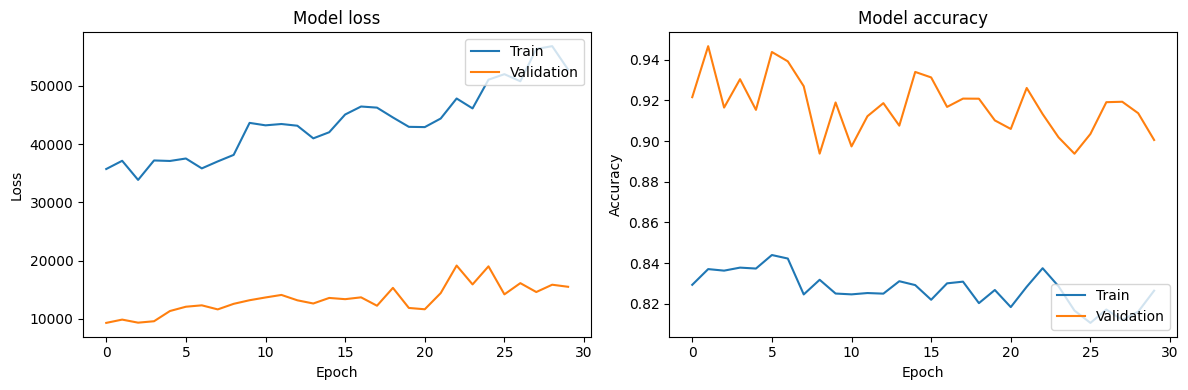

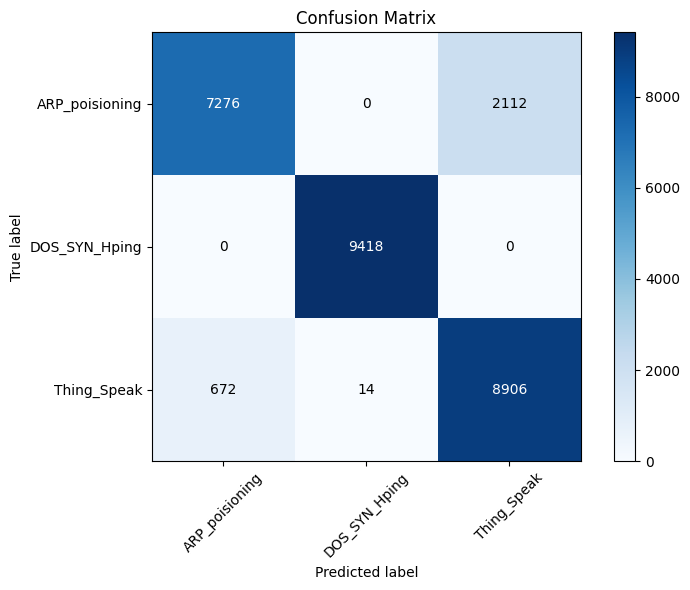

In [93]:
# Plot loss curves
plot_loss(model_history_privacy)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred_binary_mlp_privacy)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

num_classes = conf_matrix.shape[0]

# Get class labels from the LabelEncoder
class_labels = label_encoder.classes_

plt.xticks(np.arange(num_classes), class_labels, rotation=45)
plt.yticks(np.arange(num_classes), class_labels)

thresh = conf_matrix.max() / 2.

# Add text annotations
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

# Precision-Recall Curve
# precision, recall, thresholds = precision_recall_curve(y_test_binary_true, y_test_pred_binary_mlp_privacy)
# area_under_curve = auc(recall, precision)

# plt.figure(figsize=(8, 6))
# plt.plot(recall, precision, label=f'Privacy Model Precision-Recall Curve (AUC = {area_under_curve:.2f})')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Privacy Model Precision-Recall Curve')
# plt.legend(loc='lower left')
# plt.show()

In [94]:
# Extract trainable variables from the model
trainable_variables = mlp_model_privacy.trainable_variables

# Compute privacy budget
privacy_report = compute_dp_sgd_privacy.compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy_statement(
    number_of_examples=len(X_train_scaled),
    batch_size=32,
    noise_multiplier=1.3,
    num_epochs=30,
    delta=1e-5
)

In [95]:
print(privacy_report)

DP-SGD performed over 212982 examples with 32 examples per iteration, noise
multiplier 1.3 for 30 epochs with microbatching, and no bound on number of
examples per user.

This privacy guarantee protects the release of all model checkpoints in addition
to the final model.

Example-level DP with add-or-remove-one adjacency at delta = 1e-05 computed with
RDP accounting:
    Epsilon with each example occurring once per epoch:        74.229
    Epsilon assuming Poisson sampling (*):                      1.714

No user-level privacy guarantee is possible without a bound on the number of
examples per user.

(*) Poisson sampling is not usually done in training pipelines, but assuming
that the data was randomly shuffled, it is believed that the actual epsilon
should be closer to this value than the conservative assumption of an arbitrary
data order.

